In [1064]:
#Question 1

'''Implement the template based chord recognition algorithm. Define a function that takes as input the
path to a wav file and returns the estimated chords sequence labels.
The output must be a list

λ_pred = [λ_pred0, λpred_1, ..., λpred_N−1] (1)

where each element λpred_n is the predicted chord label for the time frame n. 
The length of the list depends on the feature rate, i.e., both on the window length and hop size 
used for the chromagram computation and on the downsampling factor, if feature downsampling is 
applied.

The chord templates to be considered are the major triads and the minor triads, leading to a total of 24 templates.
Once the function is defined in the notebook, test the function on the wav file Beatles LetItBe.wav,
available in /data/wav/ folder, and print or plot the output.

Explain in the report the idea behind the template-based chord recognition algorithm and detail each
step implemented in the code, including pre processing and post processing phases.
'''
#Import all packages

import os, sys
import math
from math import modf
import sys
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
%matplotlib inline

def generate_template_matrix(templates):
    template_matrix = np.zeros((12, 12 * templates.shape[1]))
    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)
    return template_matrix

def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    
    K, N = X.shape
    X_norm = np.zeros((K, N))
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
                
    if norm == 'max':
        if v is None:
            v = np.ones(K)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    return X_norm

def smooth_downsample_feature_sequence(X, Fs, filt_len, down_sampling, w_type='boxcar'):

    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

def analysis_template_match(chromagram, templates, smoothing_window_length, smoothing_down_sampling,
                            Fs, norm_chromagram='2', norm_output='2'):
    
    chroma_normalized = normalize_feature_sequence(chromagram, norm=norm_chromagram)
    if smoothing_window_length and smoothing_down_sampling:
        chroma_normalized, Fs_feat = smooth_downsample_feature_sequence(chroma_normalized, 
                                                                        down_sampling=smoothing_down_sampling,
                                                                        filt_len=smoothing_window_length, Fs=Fs)
    templates_normalized = normalize_feature_sequence(templates, norm=norm_chromagram)
    chord_similarity = np.matmul(templates_normalized.T, chroma_normalized)
    if norm_output:
         chord_similarity = normalize_feature_sequence(chord_similarity, norm=norm_output)
    
    chord_max = (chord_similarity == chord_similarity.max(axis=0)).astype(int)
    return chord_similarity, chord_max

def chordList(templates, template_sequence):
    template_sequence[template_sequence != 0] = 1 #evidenzia bene le note nella matrice in uscita
    chords = [] #inizializza la lista degli accordi
    
    #analizza ogni campione della matrice dell'audio e di quella di riferimento mettendoli a confronto
    #quando i campioni corrispondono assegna il nome dell'accordo all'array chords
    for i in range(template_sequence.shape[1]):
        for j in range(templates.shape[1]):
            if(np.array_equal(template_sequence[:,i], templates[:,j])): 
                #majorChords
                if(j==0):
                    chords.append("C")
                if(j==1):
                    chords.append("C#")
                if(j==2):
                    chords.append("D")
                if(j==3):
                    chords.append("D#")
                if(j==4):
                    chords.append("E")
                if(j==5):
                    chords.append("F")
                if(j==6):
                    chords.append("F#")
                if(j==7):
                    chords.append("G")
                if(j==8):
                    chords.append("G#")
                if(j==9):
                    chords.append("A")
                if(j==10):
                    chords.append("A#")   
                if(j==11):
                    chords.append("B")
                    
                #minorChords
                if(j==12):
                    chords.append("Cm")
                if(j==13):
                    chords.append("C#m")
                if(j==14):
                    chords.append("Dm")
                if(j==15):
                    chords.append("D#m")
                if(j==16):
                    chords.append("Em")
                if(j==17):
                    chords.append("Fm")
                if(j==18):
                    chords.append("F#m")
                if(j==19):
                    chords.append("Gm")
                if(j==20):
                    chords.append("G#m")
                if(j==21):
                    chords.append("Am")
                if(j==22):
                    chords.append("A#m")   
                if(j==23):
                    chords.append("Bm")
    return chords

#funzione che prende in ingresso un path di un segnale audio
#def template_based_chord_recognigtion(audioPath):  
def template_based_chord_recognigtion(audioPath, L=None, D=None, norm = '2', H = N):
    #Generate Chord Template Matrix
    template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
    template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T
    templates = generate_template_matrix(np.concatenate((template_cmaj, template_cmin), axis=1))
  
    #Parameters
    Fs = 22050
    N = Fs
    #N = 1024
    H = H
    #H = int(N/H_div)
    #H = 2048
    
    #Read audio
    x, Fs = librosa.load(audioPath, sr=Fs)
    
    #Algorithm
    X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
    X = np.abs(X) ** 2
    
    #logarithmic compression
    gamma = 0.1
    X = np.log(1 + gamma * np.abs(X) ** 2)
    
    #chromagram
    C = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, hop_length=H, n_fft=N, norm=None)
    
    #analize chords
    chords_sim, chords_max = analysis_template_match(C, templates, 
                                                smoothing_window_length=L,
                                                smoothing_down_sampling=D, 
                                                Fs=Fs,
                                                norm_chromagram='2', 
                                                norm_output='max')
    # Compute normalized binary templates of analysis
    templates_normalized = normalize_feature_sequence(templates, norm=norm)
    # by multipling the most probable chords by the templates (normalized), you obtain the sequence of chords chroma
    # by chroma
    
    #matrice contentente gli array degli accordi in binario
    template_sequence = np.matmul(templates_normalized, chords_max)
    #template_sequence_del = np.delete(template_sequence, template_sequence.shape[1] - 1, axis=1) #per far combaciare le dimensioni delle matrici

    #crea la matrice degli accordi in stringhe
    #chords = chordList(templates, template_sequence_del)
    chords = chordList(templates, template_sequence)
    
    #return chords, template_sequence_del, templates, Fs, N, H
    return chords, template_sequence, templates, Fs, N, H

#Execute function
audioWav = os.path.join('data','wav', 'Beatles_LetItBe.wav')#read the path
chords_WAV, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(audioWav)#ritorna gli accordi

#Plot
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
chord_label_maj = chroma_label
chord_label_min = [s + 'm' for s in chroma_label]
chord_labels = chord_label_maj + chord_label_min

print(chords_WAV, len(chords_WAV))

['C', 'C', 'G', 'G', 'Am', 'C', 'F', 'C', 'C', 'G', 'F', 'Em', 'C', 'C', 'C', 'G', 'G', 'C#m', 'Dm', 'F', 'Em', 'E', 'G', 'Dm', 'C', 'C', 'C', 'C', 'G', 'D', 'D', 'D', 'Dm', 'Em', 'E', 'G', 'Bm', 'C', 'Em', 'C', 'Em', 'Em', 'A#', 'Am', 'C', 'C', 'Em', 'Em', 'G', 'Dm', 'F', 'C', 'C', 'Am', 'Gm', 'Dm', 'E', 'C#', 'Dm', 'E', 'E', 'G', 'Dm', 'Dm', 'C', 'C', 'C', 'Gm', 'D', 'E', 'G', 'Dm', 'E', 'E', 'G', 'Bm', 'C', 'C', 'Gm', 'Am', 'C', 'Em', 'C', 'Am', 'Cm', 'C', 'Em', 'Em', 'G', 'Dm', 'A#', 'Em', 'Am', 'G', 'G', 'G', 'Am', 'C', 'C', 'Em', 'Em', 'G', 'Bm', 'C', 'C', 'Am', 'G', 'C', 'Dm', 'G', 'Dm', 'Gm', 'F', 'F', 'C', 'F', 'G', 'F', 'A#', 'Am', 'C', 'G', 'G', 'D#', 'Gm', 'C', 'C', 'Am', 'D#', 'Gm', 'A', 'G', 'Gm', 'C', 'Gm', 'G', 'G', 'A', 'Gm', 'E', 'C', 'C', 'Am', 'Em', 'G', 'C', 'Am', 'Am', 'C', 'G', 'Bm', 'Am', 'A', 'C', 'Em', 'C', 'G', 'Bm', 'Dm', 'F', 'C', 'G', 'Em', 'G', 'D', 'E', 'D', 'D', 'Em', 'C', 'Gm', 'Bm', 'Dm', 'Gm', 'G', 'G', 'C', 'G', 'G', 'E', 'C#m', 'Dm', 'C', 'F', 'D',

In [1065]:
#Question 2
'''
Write a function to load and preprocess a reference annotation (or ground truth) file, saved in CSV
format. The function should take as input the path to a CSV file and produce as output a list of ground
truth chord labels, after suitable pre processing. The output must be a list

λgt = [λgt0, λgt1, ..., λgtN−1] (2)

where each element λgtn is the ground truth chord label for the time window n. 
The length of the list must be adapted to match the the feature rate.

The reference annotations stored in the CSV file are given in the form of labelled segments, each
specified as a triplet (start, end, λ) where start and end are expressed in seconds. To load the CSV file
check the csv library (distributed with Python) or Pandas library (needs to be installed).

In the preprocessing step you should
• convert the segment-based annotation into a frame-based label sequence adapted to the feature rate
used for the chroma sequence;
• convert the labels used in the annotation file to match the chord labels used for the chord recognition
algorithm in terms of enharmonic equivalence (i.e., Db = C# );

• reduce the chord label set used in the annotation to match the chord labels set used for the chord
recognition algorithm (i.e., DMaj6 → D); for this step you can choose any reduction strategy.

Once the function is defined in the notebook, test the function on the CSV file Beatles LetItBe.csv,
available in /data/csv/ folder, and print or plot the output.
Explain in the report each step of the preprocessing phase, focusing in particular on the reduction
strategy of the chord label set.
'''
def chordsFromCsv(path):
    import csv
    with open(path) as csv_file:
        
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        chords = []
        i = 0;
        note = ['C','D','E','F','G','A','B']
        
        #delta_t_wav =  N / Fs #intervallo temporale di ogni campione
        delta_t_wav =  H / Fs #intervallo temporale di ogni campione
        
        delta_t_csv = []        
        chordsCSV_adapted = []        
        nRep_chord = []
        
        for row in csv_reader:
            
            if line_count == 0:
                line_count += 1
            else:
                delta_t_csv.append(row[1]) #estraggo gli intervalli temporali in una lista
                if "min" in row[2].split(':'):
                    temp = row[2].split(':')[0]+'m'
                else:
                    temp = row[2].split(':')[0]
                
                chords.append(temp.split('/')[0])

        for e in chords:
            if 'b' in e:
                chords[i]=note[note.index(chords[i][0])-1]+'#'
            i += 1   
        
       
        frame = 0
        #per ogni intervallo estraggo quante ripetizioni di accordi ho della lista CSV
        for i in range(len(delta_t_csv)):
            x = (float(delta_t_csv[i]) / delta_t_wav) - frame
            nRep_chord.append(int(math.ceil(x)))
            frame = (frame + nRep_chord[i]) 
            
        for i in range(len(chords)):
            for j in range(nRep_chord[i]):    
                chordsCSV_adapted.append(chords[i])
                
        if (len(chordsCSV_adapted) != len(chords_WAV)): 
            diff = np.abs(len(chordsCSV_adapted) - len(chords_WAV))
            for i in range(diff):
                if(len(chordsCSV_adapted) > len(chords_WAV)):
                    chordsCSV_adapted.pop() #rimuovi l'ultimo valore
                elif (len(chords_WAV) > len(chordsCSV_adapted)):
                    chords_WAV.pop()
            
    return chordsCSV_adapted

audioCSV = os.path.join('data','csv', 'Beatles_LetItBe.csv') 
chords_CSV = chordsFromCsv(audioCSV);
print(chords_CSV, len(chords_CSV))           


['C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'C', 'C', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'G', 'G', 'F', 'F', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'Am', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C',

In [1066]:
#Question 3
'''
Propose a metric for evaluating the template based chord recognition algorithm. 
A metric

m = f(λ_pred,λ_gt) (3)

is a scalar number that expresses how good is the algorithm in performing the task of chord recognition.
The proposed metric should have higher values when the chord recognition algorithm is able to predict
correctly the ground truth chords most of the times, lower values if the chord recognition algorithm often
fails at recognising the chords.

Write a function that takes as input the list of predicted chord labels, the list of ground truth chord
labels and computes the proposed metric value. The two input lists must have same length and the
output must be a scalar value.

Once the function is defined in the notebook, test the function on the two lists of predicted and ground
truth chord labels computed in Question 1 and Question 2.

In the report write a formal definition of the proposed metric and thoroughly explain the idea behind
the proposal. Can you imagine a musically informed strategy that weights differently mismatch errors of
the chord recognition algorithm?
'''
def csv_notes(chordsCSV, templates):
    
    chordsCSV_notes = np.zeros((12, len(chordsCSV)))
    #converti csv in accordi
    for i in range(len(chordsCSV)):
        for j in range(templates.shape[1]):    
            #majorChords
            if(chordsCSV[i] == 'C'):
                chordsCSV_notes[:, i] = templates[:,0]
                    
            if(chordsCSV[i] == 'C#'):
                chordsCSV_notes[:, i] = templates[:,1]
                    
            if(chordsCSV[i] == 'D'):
                chordsCSV_notes[:, i] = templates[:,2]
                    
            if(chordsCSV[i] == 'D#'):
                chordsCSV_notes[:, i] = templates[:,3]
                    
            if(chordsCSV[i] == 'E'):
                chordsCSV_notes[:, i] = templates[:,4]
                    
            if(chordsCSV[i] == 'F'):
                chordsCSV_notes[:, i] = templates[:,5]
                    
            if(chordsCSV[i] == 'F#'):
                chordsCSV_notes[:, i] = templates[:,6]
                    
            if(chordsCSV[i] == 'G'):
                chordsCSV_notes[:, i] = templates[:,7]
                    
            if(chordsCSV[i] == 'G#'):
                chordsCSV_notes[:, i] = templates[:,8]
                    
            if(chordsCSV[i] == 'A'):
                chordsCSV_notes[:, i] = templates[:,9]
                    
            if(chordsCSV[i] == 'A#'):
                chordsCSV_notes[:, i] = templates[:,10]
                    
            if(chordsCSV[i] == 'B'):
                chordsCSV_notes[:, i] = templates[:,11]
                
            #minorChords
            if(chordsCSV[i] == 'Cm'):
                chordsCSV_notes[:, i] = templates[:,12]
                    
            if(chordsCSV[i] == 'C#m'):
                chordsCSV_notes[:, i] = templates[:,13]
                    
            if(chordsCSV[i] == 'Dm'):
                chordsCSV_notes[:, i] = templates[:,14]
                    
            if(chordsCSV[i] == 'D#m'):
                chordsCSV_notes[:, i] = templates[:,15]
                    
            if(chordsCSV[i] == 'Em'):
                chordsCSV_notes[:, i] = templates[:,16]
                    
            if(chordsCSV[i] == 'Fm'):
                chordsCSV_notes[:, i] = templates[:,17]
                    
            if(chordsCSV[i] == 'F#m'):
                chordsCSV_notes[:, i] = templates[:,18]
                    
            if(chordsCSV[i] == 'Gm'):
                chordsCSV_notes[:, i] = templates[:,19]
                    
            if(chordsCSV[i] == 'G#m'):
                chordsCSV_notes[:, i] = templates[:,20]
                    
            if(chordsCSV[i] == 'Am'):
                chordsCSV_notes[:, i] = templates[:,21]
                    
            if(chordsCSV[i] == 'A#m'):
                chordsCSV_notes[:, i] = templates[:,22]
                    
            if(chordsCSV[i] == 'Bm'):
                chordsCSV_notes[:, i] = templates[:,23] 

    return chordsCSV_notes
                        
def metric(wav, csv):
    
    chordsCSV_notes = csv_notes(csv, templates)
    error = []
    for i in range(chordsCSV_notes.shape[1]):#guardo le colonne
        c = 0
        for j in range(chordsCSV_notes.shape[0]):#guardo le righe
            if(chordsCSV_notes[j,i] == 1 and chordsCSV_notes[j,i] == wav[j,i]):
                #print(chordsCSV_notes.shape, wav.shape)
                #print(chordsCSV_notes[j,i],wav[j,i])
                c += 1 #conto il numero di note in comune nella stessa posizione             
        
        #inserisco i gradi di errore nella lista degli errori
        if(c == 3):
            error.append(0)
        if(c == 2):
            error.append(1)
        if(c == 1):
            error.append(2)
        if(c == 0):
            error.append(3)
    #print(error)
    m = 100 - (100*(np.sum(error)/(3*len(error)))) #where 3 è il grado massimo di errore.
    m_round = round(m,2)
    return m_round

#Execute function
wav = template_sequence
m = metric(wav, chords_CSV)
print(m)

62.55


In [1067]:
#Question 4
'''
Compute the proposed metric for the remaining 3 songs:
• audio Beatles HereComesTheSun.wav, CSV Beatles HereComesTheSun.csv
• audio Beatles PennyLane.wav, CSV Beatles PennyLane.csv
• audio Beatles ObLaDiObLaDa.wav, CSV Beatles ObLaDiObLaDa.csv
all contained in folders /data/wav/ and /data/csv/. Print or plot the metric values.
'''
#Here comes the sun
chords_WAV, wav1, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'))
csv1 = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
m1 = metric(wav1, csv1)
print(m1)

#PennyLane
chords_WAV, wav2, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'))
csv2 = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
m2 = metric(wav2, csv2)
print(m2)

#ObLaDiObLaDa
chords_WAV, wav3, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'))
csv3 = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
m3 = metric(wav3, csv3)
print(m3)


50.27
61.67
47.97


Metrics_SmoothLenChange
Beatles_LetItBe [62.55, 52.87, 58.2]
Beatles_HereComesTheSun [50.27, 41.94, 46.06]
Beatles_PennyLane [61.67, 56.34, 51.27]
Beatles_ObLaDiObLaDa [47.97, 52.28, 56.14]


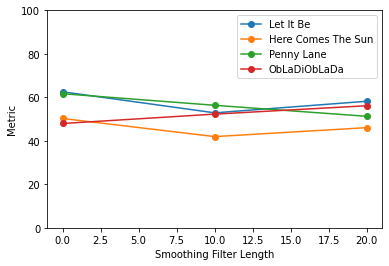

Metrics_DownsamplingChange
Beatles_LetItBe [57.92, 53.01, 61.79]
Beatles_HereComesTheSun [49.46, 51.77, 60.22]
Beatles_PennyLane [39.49, 38.41, 47.31]
Beatles_ObLaDiObLaDa [56.14, 58.33, 61.46]


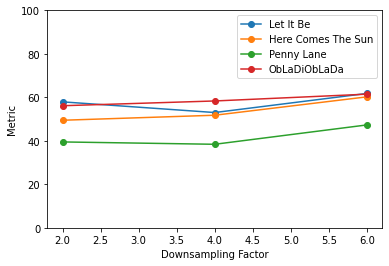

Metrics_NormChange
Beatles_LetItBe [62.55, 62.55, 62.55]
Beatles_HereComesTheSun [50.27, 50.27, 50.27]
Beatles_PennyLane [61.67, 61.67, 61.67]
Beatles_ObLaDiObLaDa [47.97, 47.97, 47.97]


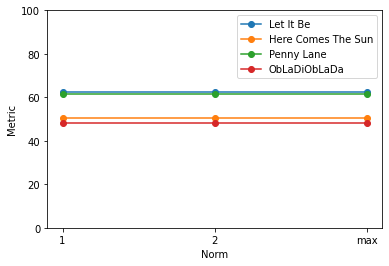

Metrics_HopsizeChange
Beatles_LetItBe [61.72, 62.44, 62.49]
Beatles_HereComesTheSun [50.72, 51.47, 51.44]
Beatles_PennyLane [62.13, 62.55, 62.91]
Beatles_ObLaDiObLaDa [50.79, 49.07, 49.77]


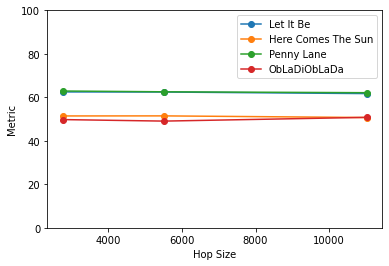

In [1074]:
#Question 5
'''
Analyse how algorithm parameters affect the performance of the templated based chord recognition
algorithm.
Given one algorithm parameter (i.e., smoothing filter length L), choose a range of 3 possible values
for it (i.e.,L = [0, 10, 20] ). 
For each value of the parameter, compute the predicted labels and the correspondent metric value for each song.
This produces a list of 3 metric values for each song.

Plot the results for all songs in a figure where the x-axis corresponds to the parameter values, the
y-axis corresponds to metric values. An example of the plot is in Figure 1.

Repeat this for at least 3 different algorithm parameters. 
Note that in every experiment you need to change only one parameter value at a time, while the others must be fixed.

Show the 3 plots both in the Jupyter Notebook and in the report. 
What considerations can you do from the 3 plots that you have? 
Are some algorithm parameters affecting the results more than others?
Comment the results in the report.
'''

L = [0, 10, 20]
D = 1 #downsampling initial value
print('Metrics_SmoothLenChange')

#LetItBe
m1 = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe', m1)

#HereComesTheSun
m2 = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun',m2)

#PennyLane
m3 = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane',m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L[i], D=2)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa',m4)

#Plot Metrics_Smoothing_Change
plt.plot(L, m1, marker='o', label = 'Let It Be')
plt.plot(L, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(L, m3, marker='o', label = 'Penny Lane')
plt.plot(L, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('Smoothing Filter Length')
plt.ylabel('Metric')
plt.show()


L = 20 #smoothing list length initial value
D = [2, 4, 6]
print('Metrics_DownsamplingChange')

#LetItBe
m1 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe', m1)

#HereComesTheSun
m2 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun', m2)

#PennyLane
m3 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane', m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa', m4)

#Plot Metrics
plt.plot(D, m1, marker='o', label = 'Let It Be')
plt.plot(D, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(D, m3, marker='o', label = 'Penny Lane')
plt.plot(D, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('Downsampling Factor')
plt.ylabel('Metric')
plt.show()


L = None
D = None
norma = ['1','2','max']
print('Metrics_NormChange')

#LetItBe
m1 = []
for i in range(len(norma)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D, norma[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe',m1)

#HereComesTheSun
m2 = []
for i in range(len(norma)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D, norma[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun',m2)

#PennyLane
m3 = []
for i in range(len(norma)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D, norma[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane',m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(norma)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D, norma[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa',m4)

#Plot Metrics
plt.plot(norma, m1, marker='o', label = 'Let It Be')
plt.plot(norma, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(norma, m3, marker='o', label = 'Penny Lane')
plt.plot(norma, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('Norm')
plt.ylabel('Metric')
plt.show()



#SISTEMARE PROBLEMA!!! 
L = None
D = None
norm = '2'
Fs = 22050
N = Fs
hop = [(N/2),(N/4),(N/8)]
print('Metrics_HopsizeChange')

#LetItBe
m1 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D, norm, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe',m1)

#HereComesTheSun
m2 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D, norm, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun',m2)

#PennyLane
m3 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D, norm, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane',m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D, norm, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa',m4)

#Plot Metrics
plt.plot(hop, m1, marker='o', label = 'Let It Be')
plt.plot(hop, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(hop, m3, marker='o', label = 'Penny Lane')
plt.plot(hop, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('Hop Size')
plt.ylabel('Metric')
plt.show()

